In [1]:
from imblearn_utils import *
from sklearn.datasets import make_classification
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

这一节关注不同的影响因素对不同分类模型的影响，在这之前，首先需要介绍对不平衡分类比较合理的性能评估指标，常用的这三项$F_{mean},G_{mean},AUC$，这里对$G_{mean}$单独说一下，它是各类准确率的几何平均：  

$$
G_{mean}=(\prod_{i=1}^nAcc_i)^{\frac{1}{n}}
$$  

这里，$n$表示类别数，$Acc_i$表示第$i$类的准确率，特别地，对于二分类有$G=\sqrt{TPR\times TNR}$  

接下来，利用上一节的4类数据（类间不平衡，数据交叠，异常点、类内不平衡）对一些常用的模型进行建模，并比较这三项指标的变化，主要进行比较的模型包括lr,nb,svm,rf,gbdt这几种

In [2]:
#sklearn中没有对G_{mean}的计算，这里定义一个
def g_score(y_true,y_pre):
    y_set=set(y_true)
    accs=[]
    for y_label in y_set:
        accs.append(np.sum((y_true==y_label)*(y_pre==y_label))/np.sum(y_true==y_label))
    g_score=1.0
    for acc in accs:
        g_score*=acc
    return np.power(g_score,1.0/len(accs))

In [3]:
#造数据
n_samples=500
X1, y1 = make_classification(n_samples=n_samples, n_features=2,
                           n_informative=2,n_redundant=0,
                           n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,weights=[0.05, 0.95],
                           class_sep=3, random_state=0)
X2, y2 = make_classification(n_samples=n_samples, n_features=2,
                           n_informative=2,n_redundant=0,
                           n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,weights=[0.05, 0.95],
                           class_sep=0.9, random_state=0)
X3, y3 = make_classification(n_samples=n_samples, n_features=2,
                           n_informative=2,n_redundant=0,
                           n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,weights=[0.05, 0.95],
                           class_sep=3,flip_y=0.1, random_state=0)
X4, y4 = make_classification(n_samples=n_samples, n_features=2,
                           n_informative=2,n_redundant=0,
                           n_repeated=0, n_classes=2,
                           n_clusters_per_class=2,weights=[0.05, 0.95],
                           class_sep=3.0,random_state=0)

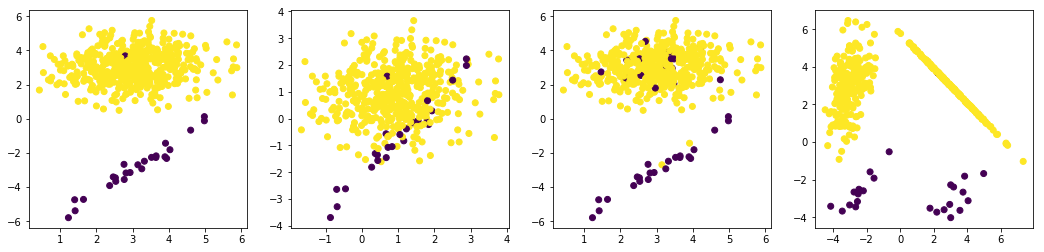

In [4]:
plt.figure(figsize = (18,4))
plt.subplot(1,4,1)
plt.scatter(x=X1[:,0],y=X1[:,1],c=y1)
plt.subplot(1,4,2)
plt.scatter(x=X2[:,0],y=X2[:,1],c=y2)
plt.subplot(1,4,3)
plt.scatter(x=X3[:,0],y=X3[:,1],c=y3)
plt.subplot(1,4,4)
plt.scatter(x=X4[:,0],y=X4[:,1],c=y4)

In [5]:
#导入模型
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,f1_score
#封装训练过程并返回指标
def train(Model,X,y):
    if Model.__name__=="SVC":
        model=Model(probability=True)
    else:
        model=Model()
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=0)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    y_pred_proba=model.predict_proba(X_test)
    return model,f1_score(y_test,y_pred,average='macro'),g_score(y_test,y_pred),roc_auc_score(y_test,y_pred_proba[:,1],average="macro")

In [7]:
#定义决策边界绘图函数
#copy from:https://imbalanced-learn.org/stable/auto_examples/under-sampling/plot_comparison_under_sampling.html#sphx-glr-auto-examples-under-sampling-plot-comparison-under-sampling-py
def plot_decision_function(X, y, clf, plt):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

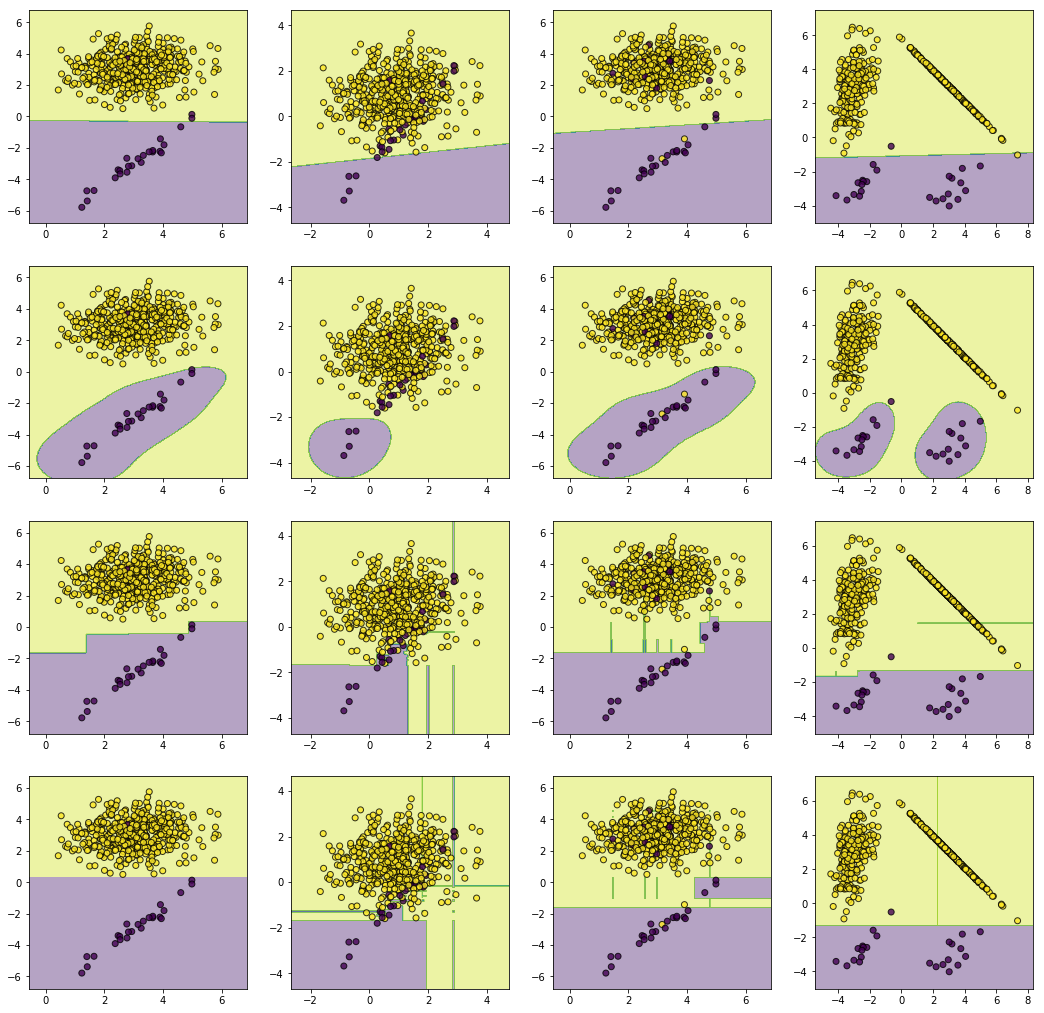

In [8]:
#训练
plt.figure(figsize = (18,18))
f1_scores=[]
g_scores=[]
aucs=[]
for i,Model in enumerate([LogisticRegression,SVC,RandomForestClassifier,GradientBoostingClassifier]):
    model_name=Model.__name__
    tmp_f1=[model_name]
    tmp_g=[model_name]
    tmp_auc=[model_name]
    for j,(X,y) in enumerate([(X1,y1),(X2,y2),(X3,y3),(X4,y4)]):
        model,f1,g,auc=train(Model,X,y)
        tmp_f1.append(f1)
        tmp_g.append(g)
        tmp_auc.append(auc)
        plt.subplot(4,4,i*4+j+1)
        plot_decision_function(X,y,model,plt)
    f1_scores.append(tmp_f1)
    g_scores.append(tmp_g)
    aucs.append(tmp_auc)

In [9]:
import pandas as pd
f1_df=pd.DataFrame(f1_scores,columns=['分类器名称','类间不平衡','数据重叠','异常值','类内不平衡'])
g_df=pd.DataFrame(g_scores,columns=['分类器名称','类间不平衡','数据重叠','异常值','类内不平衡'])
auc_df=pd.DataFrame(aucs,columns=['分类器名称','类间不平衡','数据重叠','异常值','类内不平衡'])

In [10]:
#f1值对比
f1_df

,分类器名称,类间不平衡,数据重叠,异常值,类内不平衡
0,LogisticRegression,0.938950,0.56710,0.789474,0.9519
1,SVC,0.970922,0.56710,0.855700,0.9519
2,RandomForestClassifier,0.970922,0.69278,0.794323,0.9519
3,GradientBoostingClassifier,0.970922,0.69278,0.822695,0.9519


In [11]:
#g值对比
g_df

,分类器名称,类间不平衡,数据重叠,异常值,类内不平衡
0,LogisticRegression,0.894427,0.316228,0.703336,0.912871
1,SVC,0.948683,0.316228,0.812142,0.912871
2,RandomForestClassifier,0.948683,0.544671,0.803362,0.912871
3,GradientBoostingClassifier,0.948683,0.544671,0.807764,0.912871


In [12]:
#auc对比
auc_df

,分类器名称,类间不平衡,数据重叠,异常值,类内不平衡
0,LogisticRegression,0.926667,0.736667,0.845745,1.000000
1,SVC,0.982222,0.788889,0.872340,1.000000
2,RandomForestClassifier,0.949444,0.796667,0.884752,0.913121
3,GradientBoostingClassifier,0.950000,0.821667,0.828901,0.889184


#### 简单总结一下
（1）不同因素的影响力：数据重叠>异常值>类内不平衡>类间不平衡；  
（2）评价指标的敏感度：$G_{mean}$>$F_{mean}$>$AUC$；  
（3）模型稳定性：在类间不平衡和类内不平衡的情况下，几类分类模型的表现都差不多，在数据重叠和异常值的情况下，树类的模型表现更好。  

这一节简单了解了不同因素对模型的影响力，为后续处理具体不平衡样本提供不同优先级的参考  

**注：上述总结仅做参考，实际数据会远比这些造的伪数据复杂，比如数据重叠、异常值、类内不平衡等情况都可能同时出现**